# Plot Kernel Density Estimate difference

author: steeve.laquitaine@epfl.ch

Activate environment created with python==3.9.7 and setup with installed `requirements_kilosort_silico.txt` 

```bash
source env_kilosort_silico/bin/activate
```

In [45]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.distributions.mixture_rvs import mixture_rvs
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

# Create dataset

In [10]:
# Location, scale and weight for the two distributions
dist1_loc, dist1_scale, weight1 = 3, 0.5, 0.25
dist2_loc, dist2_scale, weight2 = 1, 0.5, 0.75

# Sample from a mixture of distributions
data_1 = mixture_rvs(
    prob=[weight1, weight2],
    size=250,
    dist=[stats.norm, stats.norm],
    kwargs=(
        dict(loc=dist1_loc, scale=dist1_scale),
        dict(loc=dist2_loc, scale=dist2_scale),
    ),
) + 5

# Sample from a second mixture of distributions
dist1_loc, dist1_scale, weight1 = 4, 0.3, 0.25
dist2_loc, dist2_scale, weight2 = 1, 0.5, 0.75

data_2 = mixture_rvs(
    prob=[weight1, weight2],
    size=300,
    dist=[stats.norm, stats.norm],
    kwargs=(
        dict(loc=dist1_loc, scale=dist1_scale),
        dict(loc=dist2_loc, scale=dist2_scale),
    ),
) + 5

# create dataframe for plot
data = np.hstack([data_1, data_2])
sorter_flag = np.hstack([
    np.repeat("ground_truth", len(data_1)), 
    np.repeat("sorter", len(data_2))
    ])

df_to_plot = pd.DataFrame({
    "firing rate (spikes/sec)": data,
    "sorter": sorter_flag
})


,firing rate (spikes/sec),sorter
0,5.597922,ground_truth
1,6.564185,ground_truth
2,8.291133,ground_truth
3,5.701241,ground_truth
4,7.642296,ground_truth
...,...,...
545,9.164259,sorter
546,5.803933,sorter
547,6.588494,sorter
548,9.354732,sorter


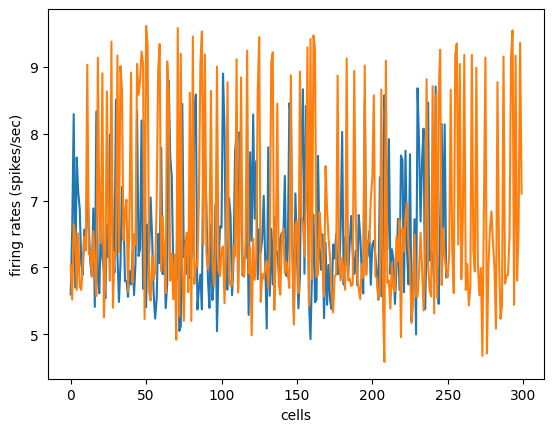

In [11]:
plt.plot(data_1);
plt.plot(data_2);
plt.ylabel("firing rates (spikes/sec)");
plt.xlabel("cells");
df_to_plot

# Fit and plot densities and the bias density

In [48]:
def get_bias_as_fr_proba_change(data_1:np.array, data_2:np.array):
    """calculate bias between two firing rates arrays as difference
    in their kernel density estimates normalized to probabilities.
    The bias is the change in the probabilities of observing each
    firing rate.

    note: we chose scipy.stats.gaussian_kde because it can 
    evaluate the densities on a common firing rate support from 
    datasets with different sample sizes and ranges of firing rates

    Args:
        data_1 (np.array): _description_
        data_2 (np.array): _description_

    Returns:
        _type_: _description_
    """
    # set parameters
    FIRING_RATE_UNIT = 0.01

    # get firing rates
    df_1 = df_to_plot["firing rate (spikes/sec)"][df_to_plot["sorter"]=="ground_truth"]
    df_2 = df_to_plot["firing rate (spikes/sec)"][df_to_plot["sorter"]=="sorter"]

    # find the common firing rate support
    min_fr = df_to_plot["firing rate (spikes/sec)"].min()
    max_fr = df_to_plot["firing rate (spikes/sec)"].max()
    firing_rate_support = np.arange(min_fr, max_fr, FIRING_RATE_UNIT)

    # estimate density (probability) for ground truth
    kde1 = scipy.stats.gaussian_kde(df_1)
    kde1 = kde1.evaluate(firing_rate_support)
    kde1_p = kde1 / sum(kde1)

    # estimate density ((probability) sorter
    kde2 = scipy.stats.gaussian_kde(df_2)
    kde2 = kde2.evaluate(firing_rate_support)
    kde2_p = kde2 / sum(kde2)

    # calculate bias
    return (kde2_p - kde1_p, firing_rate_support)

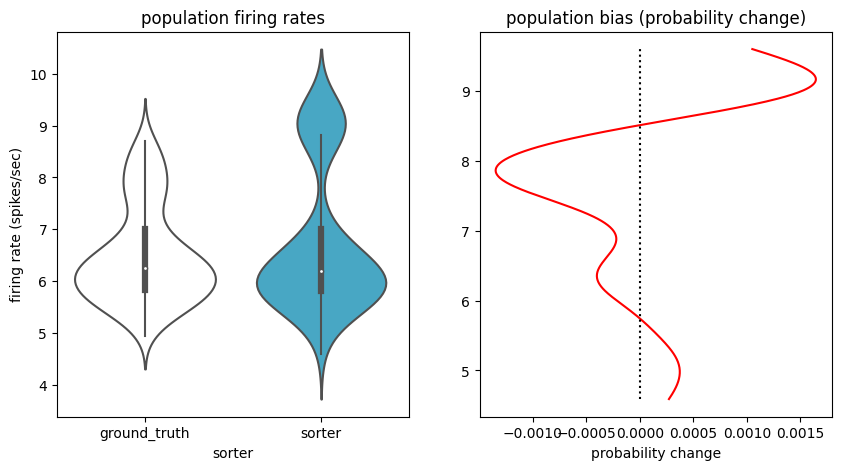

In [49]:
# plot violin kernel densities by sorter
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
my_colors = {"ground_truth": "w", "sorter": [0.2, 0.7, 0.85]}
sns.violinplot(
    data=df_to_plot,
    y="firing rate (spikes/sec)",
    x="sorter",
    ax=axes[0],
    palette=my_colors,
);
axes[0].set_title("population firing rates");

# calculate and plot bias (as probability change)
# calculate
bias, firing_rates = get_bias_as_fr_proba_change(data_1, data_2)

# plot
axes[1].plot(bias, firing_rates, "r");
axes[1].vlines(x=0, ymin=min(firing_rates), ymax=max(firing_rates), linestyle=":", color="k");
axes[1].set_xlabel("probability change");
axes[1].set_title("population bias (probability change)");